In [204]:
# Define macros

import os
import time
import cv2

IMAGES_PATH = os.path.join(r'C:\\Users\\espebh\Documents\\Project', 'data', 'man_lab_data', 'images')
LABEL_PATH = os.path.join(r'C:\\Users\\espebh\Documents\\Project', 'data', 'man_lab_data', 'labels')
AUG_IMAGES_PATH = os.path.join(r'C:\\Users\\espebh\Documents\\Project', 'data', 'aug_lab_data', 'images')
AUG_LABEL_PATH = os.path.join(r'C:\\Users\\espebh\Documents\\Project', 'data', 'aug_lab_data', 'labels')
NUMBER_IMAGES = 35
LABEL_NAMES = ['ljaw', 'ujaw', 'eye']
LABEL_MAP = dict([(y,x) for x,y in enumerate((LABEL_NAMES))])
NUM_KEYPOINTS = 3

In [205]:
# Image loading dataset

import tensorflow as tf

# Function to load image
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

# Map dataset and loader function
images = tf.data.Dataset.list_files(os.path.join(IMAGES_PATH, '*.jpg'))
images = images.map(load_image)

# Display image (numeric)
images.as_numpy_iterator().next()

array([[[105,  98,  90],
        [105,  98,  90],
        [105,  98,  90],
        ...,
        [ 54,  56,  55],
        [ 54,  56,  55],
        [ 54,  56,  55]],

       [[105,  98,  90],
        [105,  98,  90],
        [106,  99,  91],
        ...,
        [ 53,  55,  54],
        [ 53,  55,  54],
        [ 53,  55,  54]],

       [[105,  98,  90],
        [105,  98,  90],
        [106,  99,  91],
        ...,
        [ 53,  55,  54],
        [ 53,  55,  54],
        [ 53,  55,  54]],

       ...,

       [[130, 128, 115],
        [130, 128, 115],
        [130, 128, 115],
        ...,
        [ 85,  87,  82],
        [ 85,  87,  82],
        [ 85,  87,  82]],

       [[131, 129, 116],
        [131, 129, 116],
        [131, 129, 116],
        ...,
        [ 85,  87,  82],
        [ 85,  87,  82],
        [ 85,  87,  82]],

       [[132, 130, 117],
        [132, 130, 117],
        [131, 129, 116],
        ...,
        [ 86,  88,  83],
        [ 86,  88,  83],
        [ 86,  88,  83]]

In [206]:
# Create albumentations pipeline

import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb

augmentor = alb.Compose([alb.RandomCrop(width=1600, height=800), # Picture: 1920*1080
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                         bbox_params=alb.BboxParams(format='pascal_voc', label_fields=['bbox_labels', 'bbox_id']), #[x_min, y_min, x_max, y_max]
                         keypoint_params=alb.KeypointParams(format='xy',  label_fields=['keypoint_labels', 'keypoint_id'])) # [x, y]


In [207]:
# Augmentation pipeline functions

# Ensure the top left and bottom right points in the bounding box is the defining points. x_min<x_max and y_min<y_max.
def order_bbox_coords(bboxes):
    bboxes_ordered = []
    for bbox in bboxes:
        if bbox[0] > bbox[2]:
            bbox[0], bbox[2] = bbox[2], bbox[0]
        if bbox[1] > bbox[3]:
            bbox[1], bbox[3] = bbox[3], bbox[1]
        bboxes_ordered.append(bbox)
    return bboxes_ordered

# Transform the format of the manual labelling into a format that can be passed to the augmentor.
# Input: {shapes: [{label: salmon, points: [[xmin, ymin], [xmin, xmax]], group_id: c}, {...}]}
# Output: {keypoints: [[x, y], ...], bboxes: [[xmin, ymin, xmax, ymax], ...], keypoint_id: [], keypoint_labels: [], bbox_id: []}
def group_labels_for_aug(label):
    labels_grouped = {}
    labels_grouped['keypoints'] = []
    labels_grouped['bboxes'] = []
    labels_grouped['keypoint_labels'] = []
    labels_grouped['keypoint_id'] = []
    labels_grouped['bbox_id'] = []
    for item in label['shapes']:
        if item['label'] == 'eye' or item['label'] == 'ljaw' or item['label'] == 'ujaw': 
            labels_grouped['keypoints'].append(item['points'][0])
            labels_grouped['keypoint_labels'].append(item['label'])
            labels_grouped['keypoint_id'].append(item['group_id'])
        if item['label'] == 'salmon': 
            labels_grouped['bboxes'].append(list(np.concatenate([item['points'][0], item['points'][1]], axis=0)))
            labels_grouped['bbox_id'].append(item['group_id'])
    return labels_grouped

# Draw bounding boxes and keypoints on an image
# Input is the output of the augmentor, {image: array, bboxes: [(xmin, ymin, xmax, ymax), ...], bbox_labels: [], bbox_id: [], keypoints: [(x, y), ...], keypoint_id: [], keypoint_labels: []}
def draw_label_on_img(augmented):
    img = augmented['image']
    for i in range(len(augmented['bboxes'])):
        cv2.rectangle(img, 
                     (int(augmented['bboxes'][i][0]), int(augmented['bboxes'][i][1])),
                     (int(augmented['bboxes'][i][2]), int(augmented['bboxes'][i][3])), 
                    (255,0,0), 2)

    for i in range(len(augmented['keypoints'])):
        color = (0,0,0)
        if augmented['keypoint_labels'][i] == 'eye': color = (255,0,0)
        if augmented['keypoint_labels'][i] == 'ljaw': color = (0,255,0)
        if augmented['keypoint_labels'][i] == 'ujaw': color = (0,0,255)
        cv2.circle(img, 
                   (int(augmented['keypoints'][i][0]), int(augmented['keypoints'][i][1])), 5,
                   color, 2)
    return img

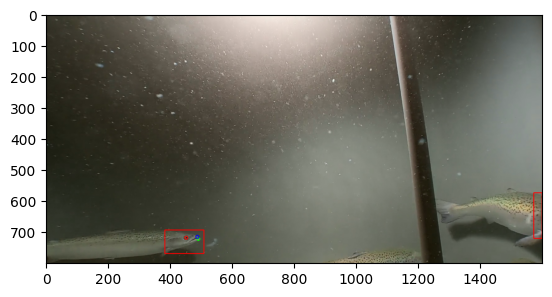

In [208]:
# Generate example image from augmentation pipeline
exmp_img = 'frame370'

# Load image and manual annotations from disk
img = cv2.imread(os.path.join(IMAGES_PATH, exmp_img + '.jpg'))
with open(os.path.join(LABEL_PATH, exmp_img + '.json'), 'r') as f:
    label = json.load(f)

# Change the format to accomodate for calling augmentor
label = group_labels_for_aug(label)

# Call augmentor
augmented = augmentor(image=img, bboxes=order_bbox_coords(label['bboxes']),
                      bbox_labels = ['salmon']*len(label['bboxes']), 
                      bbox_id =  label['bbox_id'], 
                      keypoints = label['keypoints'], 
                      keypoint_labels=label['keypoint_labels'], 
                      keypoint_id=label['keypoint_id'])
                
# Display image
plt.imshow(draw_label_on_img(augmented))

In [221]:
import copy

# Function to remove incomplete labels after augmentations
# It also structures the labels for network training
def remove_incomplete_labels(label):
    # Input is the output of the augmentor: {image: array, bboxes: [(xmin, ymin, xmax, ymax), ...], bbox_labels: [], bbox_id: [], keypoints: [(x, y), ...], keypoint_id: [], keypoint_labels: []}
    # Output is the full keypoints and bounding boxes: {keypoints: [[[]]], bboxes: [[]], areas = }. 
    # Keypoints are ordered as [boxidx][keyidx], with keyidx: ljaw: 0, ujaw: 1, eye: 2.
    # bboxes are numbered after the salmon group idx

    # Calculate area of the bounding boxes
    # Remove bounding boxes if it has no area
    bbox_dict = {}
    for i in range(len(label['bboxes'])):
        curr_area = (label['bboxes'][i][2] - label['bboxes'][i][0])*(label['bboxes'][i][3] - label['bboxes'][i][1])
        if curr_area > 0.01:
            bbox_dict[str(label['bbox_id'][i])] = list(label['bboxes'][i])

    # Initialize dictionaries
    keypoint_labels = [LABEL_MAP[x] for x in label['keypoint_labels']] # Assign a numerical value, describing type, to each keypoint [2, 0, 1, 2, ...]
    keypoint_labels_dict = dict([(y,[]) for y in bbox_dict.keys()])    # Initialize a dictionary to store keypoint labels assigned salmon-wise {1: [], 2: [], ...}
    keypoints_dict = dict([(y,[]) for y in bbox_dict.keys()])          # Initialize a dictionary to store keypoints assigned salmon-wise {1: [], 2: [], ...}

    # Fill in the dictionaries
    for idx in range(len(label['keypoint_id'])): 
        if str(label['keypoint_id'][idx]) in keypoint_labels_dict:
            keypoint_labels_dict[str(label['keypoint_id'][idx])].append(keypoint_labels[idx])
            keypoints_dict[str(label['keypoint_id'][idx])].append(np.concatenate([label['keypoints'][idx], [1]]).tolist())

    # Remove salmon if not complete
    keypoint_labels_dict = dict([(y,x) for y,x in keypoint_labels_dict.items() if len(x) == 3]) 
    keypoints_dict = dict([(y,x) for y,x in keypoints_dict.items() if len(x) == 3])

    # Create a dictionary containing only the bounding boxes and areas with a full set of keypoints
    bbox_dict = dict([(y,x) for y,x in bbox_dict.items() if y in keypoints_dict])

    # Turn the dictionaries into lists
    bboxes = list(bbox_dict.values())    
    keypoint_labels_list = list(keypoint_labels_dict.values())
    keypoints_list = list(keypoints_dict.values())
    ordered_keypoints = [[[] for i in range(len(keypoints_list[0]))] for j in range(len(keypoints_list))]

    # Find the areas of the valid bboxes
    area = [(label['bboxes'][i][2] - label['bboxes'][i][0])*(label['bboxes'][i][3] - label['bboxes'][i][1]) for i in range(len(bboxes))]
    
    # Order keypoints according to keypoint labels
    for boxidx in range(len(keypoint_labels_list)):
        for keyidx, i in enumerate(keypoint_labels_list[boxidx]):
            ordered_keypoints[boxidx][i] = keypoints_list[boxidx][keyidx]
    
    new_labels = {'bboxes': bboxes, 'keypoints': ordered_keypoints, 'areas': area}
    return new_labels

# Draw bounding boxes and keypoints on an image
# Input is the labels after incomplete salmons are removed: {keypoints: [[[]]], bboxes: [[]]}
def draw_label_on_img_after_pruning(labels, img):
    for i in range(len(labels['bboxes'])):
        cv2.rectangle(img, 
                     (int(labels['bboxes'][i][0]), int(labels['bboxes'][i][1])),
                     (int(labels['bboxes'][i][2]), int(labels['bboxes'][i][3])), 
                    (255,0,0), 2)

    for i in range(len(labels['keypoints'])):
        for j in range(0,NUM_KEYPOINTS):
            color = (0,0,0)
            if j == 0: color = (255,0,0)
            if j == 1: color = (0,255,0)
            if j == 2: color = (0,0,255)
            cv2.circle(img, 
                    (int(labels['keypoints'][i][j][0]), int(labels['keypoints'][i][j][1])), 5,
                    color, 2)
    return img



# Test remove_incomplete_labels function
labels = copy.deepcopy(augmented)
new_labels = remove_incomplete_labels(labels)

# Test plotter function
# NB: The call to the other plotter function must be commented out, to avoid double annotation
# plt.imshow(draw_label_on_img_after_pruning(new_labels, augmented['image']))


In [224]:
# Create augmentation dataset, and save to disk
for image in os.listdir(os.path.join(IMAGES_PATH)):
    # Read in image
    img = cv2.imread(os.path.join(IMAGES_PATH, image))

    # Read in label
    label_path = os.path.join(LABEL_PATH, f'{image.split(".")[0]}.json')
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = json.load(f)
        label = group_labels_for_aug(label)

    try: 
        # Augment and save an image n times
        for x in range(60):
            augmented = augmented = augmentor(image=img, bboxes=order_bbox_coords(label['bboxes']),
                        bbox_labels = ['salmon']*len(label['bboxes']), 
                        bbox_id =  label['bbox_id'], 
                        keypoints = label['keypoints'], 
                        keypoint_labels=label['keypoint_labels'], 
                        keypoint_id=label['keypoint_id'])
            cv2.imwrite(os.path.join(AUG_IMAGES_PATH, f'{image.split(".")[0]}.{x}.jpg'), augmented['image']) # Save image

            with open(os.path.join(AUG_LABEL_PATH, f'{image.split(".")[0]}.{x}.json'), 'w') as f: # Save label
                json.dump(remove_incomplete_labels(augmented), f)

    except Exception as e:
        print(e)

{'bboxes': [[131.6265060240964, 0.0, 334.03614457831327, 98.28915662650618], [1083.4337349397592, 93.46987951807239, 1200.301204819277, 174.19277108433738]], 'keypoints': [[[163.70588235294122, 7.470588235294144, 1.0], [164.68627450980398, 16.294117647058783, 1.0], [213.70588235294122, 29.529411764705856, 1.0]], [[1180.7092651757189, 135.07348242811497, 1.0], [1172.0830670926516, 144.3386581469648, 1.0], [1123.520766773163, 141.78274760383385, 1.0]]], 'areas': [19894.672666569928, 3124.9092756568634], 'image': array([[[ 74,  81,  78],
        [ 74,  81,  78],
        [ 74,  81,  78],
        ...,
        [121, 122, 126],
        [121, 122, 126],
        [121, 122, 126]],

       [[ 74,  81,  78],
        [ 74,  81,  78],
        [ 74,  81,  78],
        ...,
        [122, 123, 127],
        [121, 122, 126],
        [121, 122, 126]],

       [[ 74,  81,  78],
        [ 74,  81,  78],
        [ 74,  81,  78],
        ...,
        [122, 123, 127],
        [121, 122, 126],
        [121, 12

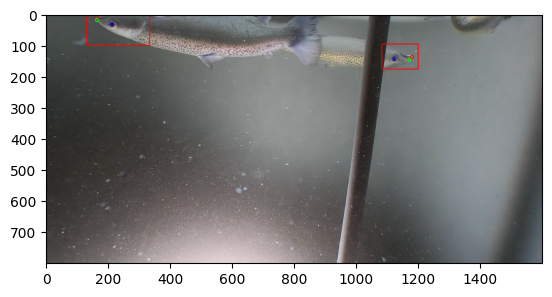

In [227]:
# View an image from the augmented dataset
img_nr = 'frame242.0'
with open(os.path.join(AUG_LABEL_PATH, img_nr + '.json'), 'r') as f:
    label = json.load(f)
img = cv2.imread(os.path.join(AUG_IMAGES_PATH, img_nr + '.jpg'))
label['image'] = img
print(label)

plt.imshow(draw_label_on_img_after_pruning(label, img))